In [1]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver #Algorithms

#Qiskit odds and ends
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeManila, FakeNairobi

#qiskit_nature
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD, HartreeFock, CHC, VSCF
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer , FreezeCoreTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms import AdaptVQE,VQEUCCFactory, GroundStateEigensolver, QEOM, NumPyEigensolverFactory, ExcitedStatesEigensolver

#Python odds and ends
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import pylab
import numpy as np
import os
import pyscf
from IPython.display import display, clear_output

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Noisy simulator
backend_aer = Aer.get_backend('aer_simulator')
device_backend=FakeManila()
device = QasmSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
#Real Devices
backend_manil = provider.get_backend('ibmq_manila')
backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')

sh=1024 #shots

#solvers
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()

In [2]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

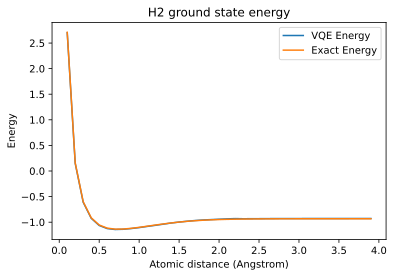

In [3]:
#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["H", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    #Get properties
    properties = driver.run()
    
    #particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_a_electrons = properties.get_property("ParticleNumber").num_alpha
    num_b_electrons = properties.get_property("ParticleNumber").num_beta
    num_particles=properties.get_property("ParticleNumber").num_particles

    num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
    num_spin_orbitals= num_spin_orbitals.item()
    type(np.float64(0).item())

    rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    en_shift=0
    #en_shift=properties.get_property("ElectronicEnergy").energy_shift
    shift=rep_energy+en_shift
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=2, #Electrons in active space
        num_molecular_orbitals=2, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver
                                        # , [
                                             #transformer 
                                         #     , FreezeCoreTransformer(freeze_core=True
                                         #                                 , remove_orbitals=[-3,-2]
                                         #                                )
                                         #  ]
                                        )
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
    sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
    converter = QubitConverter(mapper
                               #,two_qubit_reduction=True
                               ,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
    #Final OP
    qubit_op = converter.convert(hamiltonian)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem


#Set parameters, initialize result variables
distances = np.arange(0.1, 4, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()

#set backend
seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter
                   )
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    #clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

dists=[]    
for i,dist in enumerate(distances):
    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    
    #classic solver
    result_exact = exact_solver(problem, converter = converter
                          )
    exact_energies.append(result_exact.total_energies)
    
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    
    #VQE

    # Set initial parameters of the ansatz
    initial_point = [0.01]*ansatz.num_parameters

    algorithm = VQE(ansatz,
                    optimizer=optimizer,
                    quantum_instance=qi,
                    callback=callback,
                    initial_point=initial_point
                )

    vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)
    clear_output(wait=True)
    plt.plot(dists, vqe_energies, label="VQE Energy")
    plt.plot(dists, exact_energies, label="Exact Energy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.title("H2 ground state energy")
    plt.show()

In [4]:
print(problem.interpret(result_exact))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.068862047407
  - computed part:      -1.068862047407
~ Nuclear repulsion energy (Hartree): 0.135686464338
> Total ground state energy (Hartree): -0.933175583068
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [7.36993189  0.0  0.0]
 


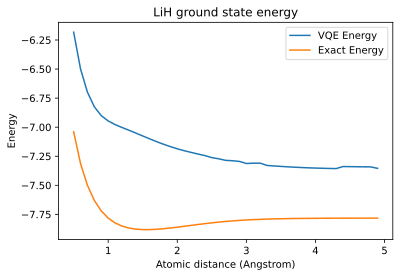

In [5]:
#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    #Get properties
    properties = driver.run()
    
    #particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_a_electrons = properties.get_property("ParticleNumber").num_alpha
    num_b_electrons = properties.get_property("ParticleNumber").num_beta
    num_particles=properties.get_property("ParticleNumber").num_particles

    num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
    num_spin_orbitals= num_spin_orbitals.item()
    type(np.float64(0).item())

    rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    en_shift=0
    #en_shift=properties.get_property("ElectronicEnergy").energy_shift
    shift=rep_energy+en_shift
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=4, #Electrons in active space
        num_molecular_orbitals=4, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver
                                         , [
                                          #   transformer 
                                                   FreezeCoreTransformer(freeze_core=True
                                                                         , remove_orbitals=[3,4]
                                                                         )
                                           ]
                                        )
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
    sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
    converter = QubitConverter(mapper
                               #,two_qubit_reduction=True
                               ,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
    #Final OP
    qubit_op = converter.convert(hamiltonian)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem




distances = np.arange(0.5, 5, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    #clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
dists=[]
for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    #VQE

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)

    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz
                    ,optimizer=optimizer
                    ,quantum_instance=qi
                    ,callback=callback
                    ,initial_point=initial_point
                   )

    vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)
    
    clear_output(wait=True)
    plt.plot(dists, vqe_energies, label="VQE Energy")
    plt.plot(dists, exact_energies, label="Exact Energy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.title("LiH ground state energy")
    plt.show()
    

In [7]:
print(noise_model.noise_instructions)

['cx', 'id', 'measure', 'reset', 'sx', 'x']


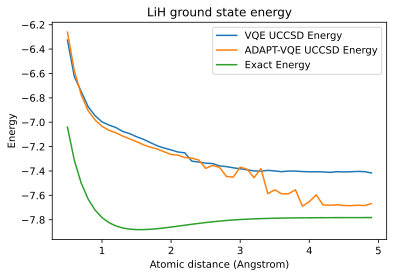

In [7]:
#### Adapt VQE Attempt

#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    #Get properties
    properties = driver.run()
    
    #particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_a_electrons = properties.get_property("ParticleNumber").num_alpha
    num_b_electrons = properties.get_property("ParticleNumber").num_beta
    num_particles=properties.get_property("ParticleNumber").num_particles

    num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
    num_spin_orbitals= num_spin_orbitals.item()
    type(np.float64(0).item())

    rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    en_shift=0
    #en_shift=properties.get_property("ElectronicEnergy").energy_shift
    shift=rep_energy+en_shift
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=4, #Electrons in active space
        num_molecular_orbitals=4, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver
                                        , [
                                         #transformer 
                                         #         , 
                                         FreezeCoreTransformer(freeze_core=True
                                                                         , remove_orbitals=[3,4]
                                                                         )
                                           ]
                                        )
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
    sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
    converter = QubitConverter(mapper,two_qubit_reduction=False,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter))
    
    #Final OP
    qubit_op = converter.convert(hamiltonian)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem




distances = np.arange(0.5, 5, 0.1)
exact_energies = []
vqe_energies = []
avqe_energies=[]
optimizer = COBYLA(maxiter=25)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
dists=[]
for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    
    #VQE
  

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)
    
    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters
    
    #VQE Solver
    solver=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         ,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
    
    #Normal VQE UCCSD
    algorithm_VQE = VQE(ansatz
                    ,optimizer=optimizer
                    ,quantum_instance=qi
                    ,callback=callback
                    ,initial_point=initial_point
                   )

    vqe_calc=algorithm_VQE.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)
    
    #ADAPT VQE
    algorithm_AVQE = AdaptVQE(converter
                         ,solver
                         ,max_iterations=20
                        )

    avqe_calc=algorithm_AVQE.solve(problem)
    avqe_energies.append(problem.interpret(avqe_calc).total_energies)
    
    #clear_output(wait=True)
    plt.plot(dists, vqe_energies, label="VQE UCCSD Energy")
    plt.plot(dists, avqe_energies, label="ADAPT-VQE UCCSD Energy")
    plt.plot(dists, exact_energies, label="Exact Energy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.title("LiH ground state energy")
    plt.show()



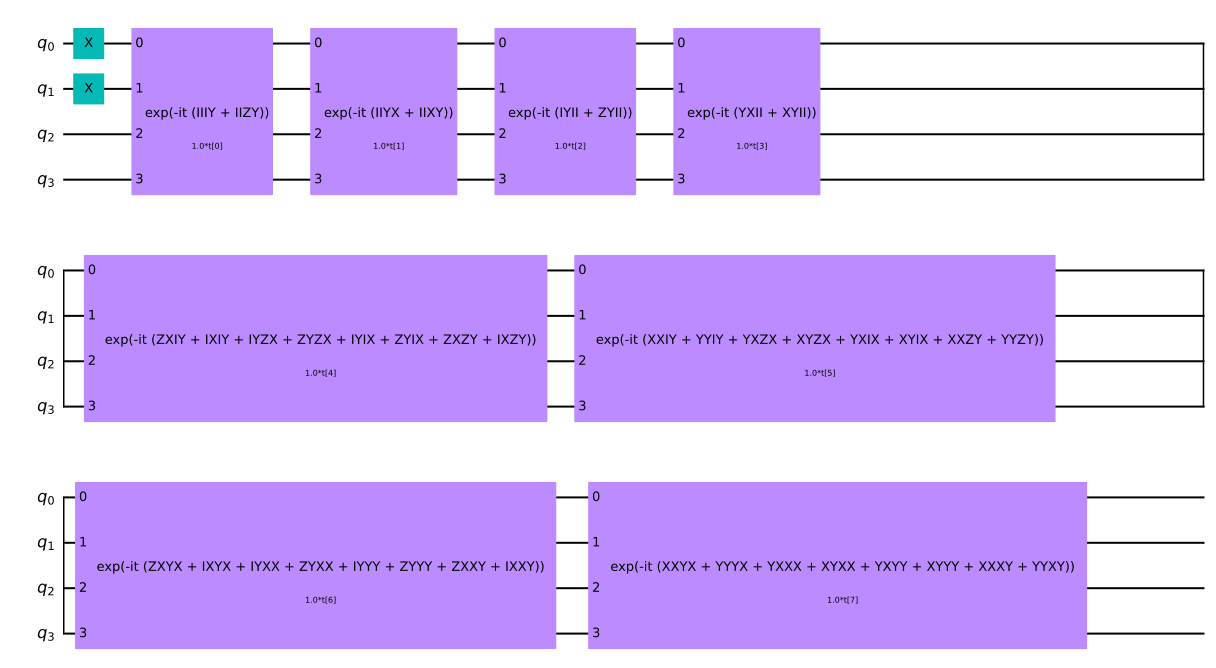

In [8]:
ansatz.decompose().draw(output='mpl')

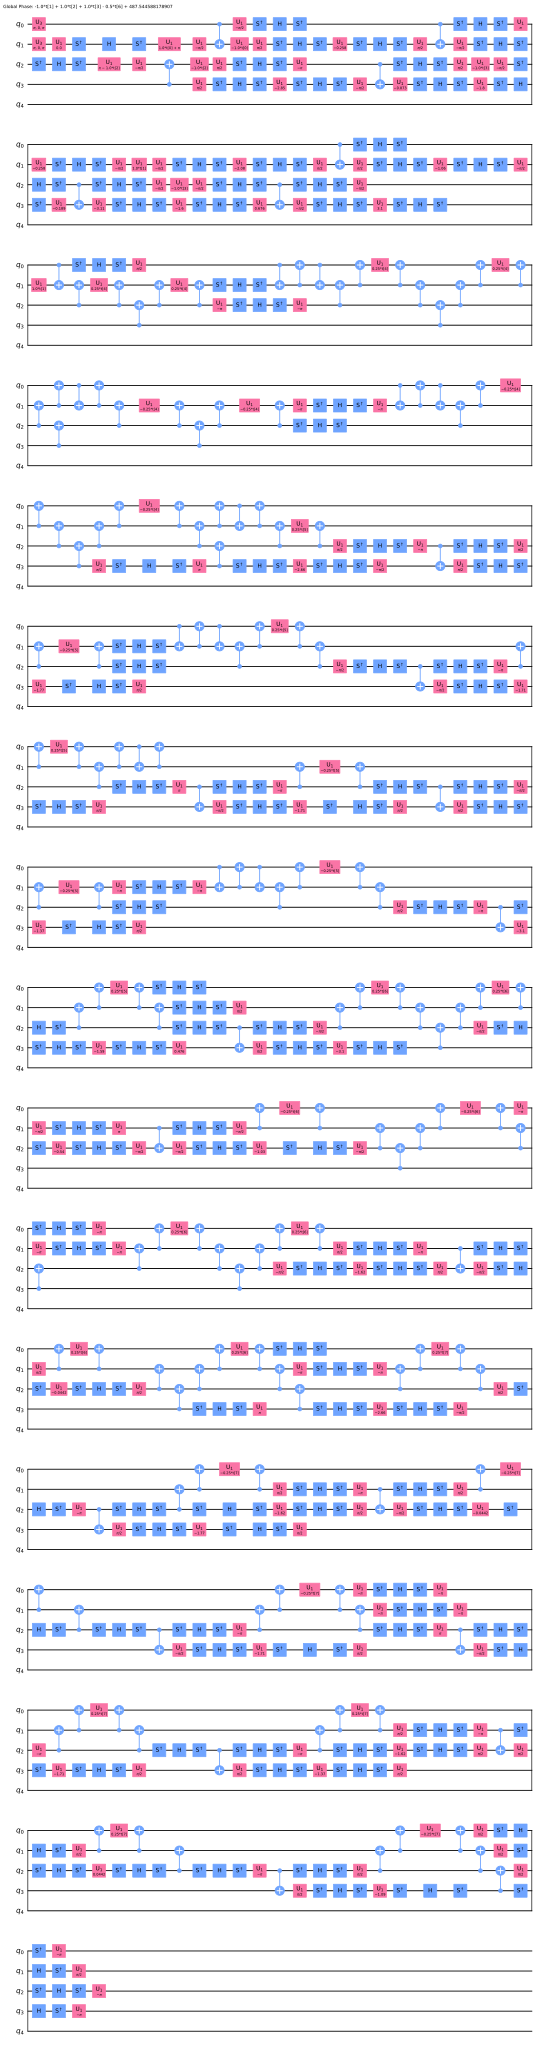

In [9]:
from qiskit.compiler import transpile

transpile(ansatz,backend_manil,optimization_level=3).decompose().draw(output='mpl')

In [ ]:
EfficientSU2(qubit_op.num_qubits,su2_gates='ry',reps=3,entanglement='linear').decompose().draw(output='mpl')
                                                                                                                                                                                           

In [11]:
ind=np.where(avqe_energies==np.amin(avqe_energies))
dist=distances[ind[0]][0]

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)

solver=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         ,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
gsc = GroundStateEigensolver(converter, solver)

qeom_excited_states_calculation = QEOM(gsc, "sd")

qeom_results = qeom_excited_states_calculation.solve(problem)
print("************QEOM Results************")
print(qeom_results)

def filt(eigenstate, eigenvalue, aux_values):
    return np.isclose(aux_values[0][0], 2.0)

np_solv = NumPyEigensolverFactory(filter_criterion=filt)
np_excited = ExcitedStatesEigensolver(converter, np_solv)
np_results = np_excited.solve(problem)
print("************Classical Results************")
print(np_results)


************QEOM Results************
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.811588161544
  - computed part:      -0.404856683537
  - FreezeCoreTransformer extracted energy part: -7.406731478007
~ Nuclear repulsion energy (Hartree): 0.407059393015
> Total ground state energy (Hartree): -7.404528768529
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -7.743921686438
> Total excited state energy (Hartree): -7.336862293423
  2: 
* Electronic excited state energy (Hartree): -7.624854362304
> Total excited state energy (Hartree): -7.217794969289
  3: 
* Electronic excited state energy (Hartree): -7.624854362304
> Total excited state energy (Hartree): -7.217794969289
  4: 
* Electronic excited state energy (Hartree): -7.58558877425
> Total excited state energy (Hartree): -7.178529381235
  5: 
* Electronic excited state energy (Hartree): -7.542135495346
> Total excited state energy (Hartree): -7.13507610233
  6: 
* Elec

In [ ]:
distances[ind[0]][0]

In [ ]:
#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["H", [-dist, 0.0, 0.0]],
            ["Be", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    #Get properties
    properties = driver.run()
    
    #particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_a_electrons = properties.get_property("ParticleNumber").num_alpha
    num_b_electrons = properties.get_property("ParticleNumber").num_beta
    num_particles=properties.get_property("ParticleNumber").num_particles

    num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
    num_spin_orbitals= num_spin_orbitals.item()
    type(np.float64(0).item())

    rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    en_shift=0
    #en_shift=properties.get_property("ElectronicEnergy").energy_shift
    shift=rep_energy+en_shift
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=6, #Electrons in active space
        num_molecular_orbitals=5, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver
                                         , [transformer 
                                                  , FreezeCoreTransformer(freeze_core=True
                                         #                                 , remove_orbitals=[-3,-2]
                                                                         )
                                           ]
                                        )
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
    sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
    converter = QubitConverter(mapper
                               #,two_qubit_reduction=True
                               ,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
    #Final OP
    qubit_op = converter.convert(hamiltonian)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem




distances = np.arange(0.5, 5, 0.1)
exact_energies = []
vqe_energies = []
avqe_energies= []
optimizer = COBYLA(maxiter=25)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
dists=[]

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    #VQE
    def callback(eval_count, parameters, mean, std):  
        # Overwrites the same line when printing
        display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
        clear_output(wait=True)
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
        deviation.append(std)

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)

    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters

    #VQE Solver
    solver=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         ,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
    
    #Normal VQE UCCSD
    algorithm_VQE = VQE(ansatz
                    ,optimizer=optimizer
                    ,quantum_instance=qi
                    ,callback=callback
                    ,initial_point=initial_point
                   )

    vqe_calc=algorithm_VQE.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)
    
    #ADAPT VQE
    algorithm_AVQE = AdaptVQE(converter
                         ,solver
                         ,max_iterations=20
                        )

    avqe_calc=algorithm_AVQE.solve(problem)
    avqe_energies.append(problem.interpret(avqe_calc).total_energies)
    
    plt.plot(dists, vqe_energies, label="Normal VQE Energy")
    plt.plot(dists, avqe_energies, label="ADAPT-VQE UCCSD Energy")
    plt.plot(dists, exact_energies, label="Exact Energy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.title("BeH2 ground fstate energy")
    plt.show()

'Evaluation: 31, Energy: -2.0165697464518235, Std: 0.011559883258733498'

In [ ]:
ind=np.where(avqe_energies==np.amin(avqe_energies))
dist=distances[ind[0]][0]

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)

solver=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         #,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
gsc = GroundStateEigensolver(converter, solver)

qeom_excited_states_calculation = QEOM(gsc, "sd")

qeom_results = qeom_excited_states_calculation.solve(problem)
print("************QEOM Results************")
print(qeom_results)

def filt(eigenstate, eigenvalue, aux_values):
    return np.isclose(aux_values[0][0], 2.0)

np_solv = NumPyEigensolverFactory(filter_criterion=filt)
np_excited = ExcitedStatesEigensolver(converter, np_solv)
np_results = np_excited.solve(problem)
print("************Classical Results************")
print(np_results)



In [14]:
init_state.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          
q_4: ─────

In [106]:
ansatz.decompose.draw()

[array([-12.94467474+0.j]),
 array([-13.53708826+0.j]),
 array([-13.97818389+0.j]),
 array([-14.2845443+0.j]),
 array([-14.5219943+0.j]),
 array([-14.61933262+0.j]),
 array([-14.70105314+0.j]),
 array([-14.7501316+0.j]),
 array([-14.78151463+0.j]),
 array([-14.77897714+0.j]),
 array([-14.7887148+0.j]),
 array([-14.76127123+0.j]),
 array([-14.74617995+0.j]),
 array([-14.72887732+0.j]),
 array([-14.71245325+0.j]),
 array([-14.69957034+0.j]),
 array([-14.7084896+0.j]),
 array([-14.70547717+0.j]),
 array([-14.6998639+0.j]),
 array([-14.70786119+0.j]),
 array([-14.70335262+0.j]),
 array([-14.70693162+0.j]),
 array([-14.69543427+0.j]),
 array([-14.652007+0.j]),
 array([-14.66348172+0.j]),
 array([-14.65803991+0.j]),
 array([-14.66795036+0.j]),
 array([-14.66571588+0.j]),
 array([-14.64114521+0.j]),
 array([-14.64360773+0.j]),
 array([-14.65250891+0.j]),
 array([-14.62979203+0.j]),
 array([-14.63098043+0.j]),
 array([-14.64045547+0.j]),
 array([-14.60543358+0.j]),
 array([-14.59686498+0.j]),


In [32]:
#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["N", [0.0, 0.0, 0.0]],
            ["H", [2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.cos(np.radians(30))/3, 2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.sin(np.radians(30))/3, ((dist**2)-(4*dist**2*(np.sin(np.radians(107))**2))/3)]],
            ["H", [2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.cos(np.radians(30))/3, -2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.cos(np.radians(30))/3, ((dist**2)-(4*dist**2*(np.sin(np.radians(107))**2))/3)]],
            ["H", [-2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.cos(np.radians(30))/3, 2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.sin(np.radians(30))/3, ((dist**2)-(4*dist**2*(np.sin(np.radians(107))**2))/3)]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    #Get properties
    properties = driver.run()
    
    #particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_a_electrons = properties.get_property("ParticleNumber").num_alpha
    num_b_electrons = properties.get_property("ParticleNumber").num_beta
    num_particles=properties.get_property("ParticleNumber").num_particles

    num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
    num_spin_orbitals= num_spin_orbitals.item()
    type(np.float64(0).item())

    rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    en_shift=0
    #en_shift=properties.get_property("ElectronicEnergy").energy_shift
    shift=rep_energy+en_shift
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=6, #Electrons in active space
        num_molecular_orbitals=4, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver)
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
    sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
    converter = QubitConverter(mapper
                               #,two_qubit_reduction=True
                               ,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
    #Final OP
    qubit_op = converter.convert(hamiltonian)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem




distances = np.arange(0.5, 4, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
qi=backend_stv
#qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
#                          coupling_map=coupling_map,noise_model=noise_model,
#                          measurement_error_mitigation_cls=CompleteMeasFitter)


for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    #VQE
    def callback(eval_count, parameters, mean, std):  
        # Overwrites the same line when printing
        display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
        clear_output(wait=True)
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
        deviation.append(std)

    counts = []
    values = []
    params = []
    deviation = []

    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz
                    , optimizer=optimizer
                    , quantum_instance=qi
                    , callback=callback
                    , initial_point=initial_point)

    vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)


plt.plot(distances, vqe_energies, label="VQE Energy")
plt.plot(distances, exact_energies, label="Exact Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.title("NH3 ground state energy")
plt.show()

KeyboardInterrupt: 

In [ ]:
print(problem.interpret(vqe_calc))
print(result_exact)

In [12]:
len(vqe_energies)

36

In [49]:
print(f"average error:{np.average((np.array(vqe_energies)-np.array(exact_energies))*1000):.5f} mHaf")

average error:264.88563+0.00000j mHaf


In [54]:
distances = np.arange(0.5, 5, 0.1)
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)


#Define Molecule
dist=5
molecule = Molecule(
        # coordinates in Angstrom
    geometry=[
        ["N", [0.0, 0.0, 0.0]],
        ["H", [2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.cos(np.radians(30))/3, 2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.sin(np.radians(30))/3, ((dist**2)-(4*dist**2*(np.sin(np.radians(107))**2))/3)]],
        ["H", [2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.cos(np.radians(30))/3, -2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.cos(np.radians(30))/3, ((dist**2)-(4*dist**2*(np.sin(np.radians(107))**2))/3)]],
        ["H", [-2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.cos(np.radians(30))/3, 2*dist*np.sin(np.radians(107))*np.sqrt(3)*np.sin(np.radians(30))/3, ((dist**2)-(4*dist**2*(np.sin(np.radians(107))**2))/3)]]
    ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
                                            molecule=molecule,
                                            basis="sto3g",
                                            driver_type=ElectronicStructureDriverType.PYSCF,
                                            )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
num_spin_orbitals= num_spin_orbitals.item()
type(np.float64(0).item())

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
en_shift=0
#en_shift=properties.get_property("ElectronicEnergy").energy_shift
shift=rep_energy+en_shift
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
                                    num_electrons=8, #Electrons in active space
                                    num_molecular_orbitals=6, #Orbitals in active space
                                    )
    
#Define the problem

problem = ElectronicStructureProblem(driver
                                     , [transformer
                                       , FreezeCoreTransformer(freeze_core=True
                                                              , remove_orbitals=[-3,-2]
                                                              )
                                      ]
                                    )
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian

#Get Pauli OP
converter = QubitConverter(mapper)
qubit_op = converter.convert(hamiltonian)
    
#Symmetries
sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
converter = QubitConverter(mapper
                               #,two_qubit_reduction=True
                               ,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
#Final OP
qubit_op = converter.convert(hamiltonian)

In [75]:
distances = np.arange(0.5, 5, 0.1)
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)


#Define Molecule
dist=5
molecule = Molecule(
        # coordinates in Angstrom
   geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
                                            molecule=molecule,
                                            basis="sto3g",
                                            driver_type=ElectronicStructureDriverType.PYSCF,
                                            )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
num_spin_orbitals= num_spin_orbitals.item()
type(np.float64(0).item())

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
en_shift=0
#en_shift=properties.get_property("ElectronicEnergy").energy_shift
shift=rep_energy+en_shift
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
                                    num_electrons=4, #Electrons in active space
                                    num_molecular_orbitals=4, #Orbitals in active space
                                    )
    
#Define the problem

problem = ElectronicStructureProblem(driver
                                     , [transformer
                                       , FreezeCoreTransformer(freeze_core=True
                                                              , remove_orbitals=[-3,-2]
                                                              )
                                      ]
                                    )
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian

#Get Pauli OP
converter = QubitConverter(mapper)
qubit_op = converter.convert(hamiltonian)
    
#Symmetries
sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
converter = QubitConverter(mapper
                               #,two_qubit_reduction=True
                               ,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
#Final OP
qubit_op = converter.convert(hamiltonian)

In [76]:
print(num_particles)

(1, 1)


In [77]:
print(qubit_op.num_qubits)

3


In [65]:
print(PN_property)

ParticleNumber:
	12 SOs
	2 alpha electrons
		orbital occupation: [1. 1. 0. 0. 0. 0.]
	2 beta electrons
		orbital occupation: [1. 1. 0. 0. 0. 0.]


In [78]:
distances = np.arange(0.1, 4, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()
backend=backend_stv

def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
#ansatz
ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
#classic solver
result_exact = exact_solver(problem, converter = converter)
exact_energies.append(np.real(result_exact.eigenenergies[0]))
#VQE
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
#initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                    optimizer=optimizer,
                    quantum_instance=backend,
                    callback=callback,
                    #initial_point=initial_point
                )
vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
vqe_energies.append(problem.interpret(vqe_calc).hartree_fock_energy)

'Evaluation: 10, Energy: -0.011535987866495767, Std: 0.0'

In [79]:
print(problem.interpret(vqe_calc))
print(result_exact)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.460116467804
  - computed part:      -0.030626498637
  - ActiveSpaceTransformer extracted energy part: 0.0
  - FreezeCoreTransformer extracted energy part: -7.429489969167
~ Nuclear repulsion energy (Hartree): 0.317506326552
> Total ground state energy (Hartree): -7.142610141252
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [9.44863062  0.0  0.0]
 
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.466008673576
  - computed part:      -0.036518704409
  - ActiveSpaceTransformer extracted energy part: 0.0
  - FreezeCoreTransformer extracted energy part: -7.429489969167
~ Nuclear repulsion energy (Hartree): 0.317506326552
> Total ground state energy (Hartree): -7.148502347024
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [9.44863062  0.0  0.0]


In [80]:
ansatz.decompose().draw()

┌───┐┌─────────────────────────────────┐»
q_0: ┤ X ├┤0                                ├»
     └───┘│                                 │»
q_1: ─────┤1 exp(-it (IIY + ZIY))(1.0*t[0]) ├»
          │                                 │»
q_2: ─────┤2                                ├»
          └─────────────────────────────────┘»
«     ┌─────────────────────────────────┐»
«q_0: ┤0                                ├»
«     │                                 │»
«q_1: ┤1 exp(-it (IYI + ZYI))(1.0*t[1]) ├»
«     │                                 │»
«q_2: ┤2                                ├»
«     └─────────────────────────────────┘»
«     ┌─────────────────────────────────────────────┐»
«q_0: ┤0                                            ├»
«     │                                             │»
«q_1: ┤1 exp(-it (ZXY + IXY + IYX + ZYX))(1.0*t[2]) ├»
«     │                                             │»
«q_2: ┤2                                            ├»
«     └─────────────────────────────────────────────┘»
«     ┌─────────────────────────────────────────────┐
«q_0: ┤0                                            ├
«     │                                             │
«q_1: ┤1 exp(-it (YXX + XYX + XXY + YYY))(1.0*t[3]) ├
«     │                                             │
«q_2: ┤2                                            ├
«     └─────────────────────────────────────────────┘

In [245]:
PN_property = properties.get_property("ParticleNumber")
print(PN_property)

ParticleNumber:
	12 SOs
	2 alpha electrons
		orbital occupation: [1. 1. 0. 0. 0. 0.]
	2 beta electrons
		orbital occupation: [1. 1. 0. 0. 0. 0.]


In [9]:
print(result_exact.total_energies)

[-7.52480021+0.j]
